DQ= 1
DQ= 2
DQ= 3
DQ= 4


/var/folders/xh/n6q6l6890l3g5t5p_d5xt_f40000gn/T/ipykernel_54734/741615887.py:166: RuntimeWarning: divide by zero encountered in log10
  plt.plot(Trange_class, np.log10(ksi_classical),'k.')


(-20.0, 0.0)

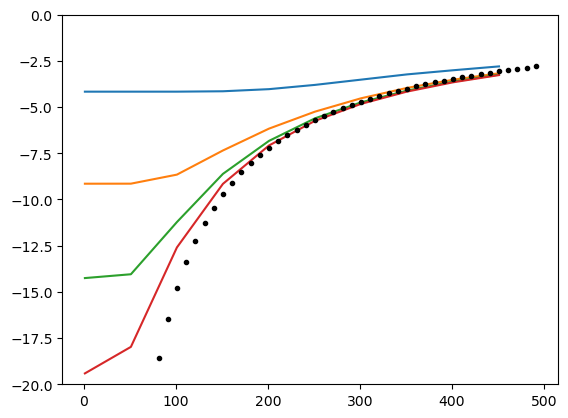

In [35]:
import numpy as np
from scipy import constants as const
from numba import jit
import matplotlib.pyplot as plt


HBAR = const.hbar / const.e                     # in units of eV.s
EV2J = const.e                                  # 1 eV in Joules
AMU2KG = const.physical_constants['atomic mass constant'][0]
ANGS2M = 1e-10                                  
factor = ANGS2M**2 * AMU2KG / HBAR / HBAR / EV2J
hb = 6.63e-34/2/np.pi

# for fast factorial calculations
LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype=np.double)

@jit
def fact(n: int) -> float:
    """Compute the factorial of n."""
    if n > 20:
        return LOOKUP_TABLE[-1] * \
            np.prod(np.array(list(range(21, n+1)), dtype=np.double))
    return LOOKUP_TABLE[n]


@jit
def herm(x: float, n: int) -> float:
    """Recursive definition of hermite polynomial."""
    if n == 0:
        return 1.
    if n == 1:
        return 2. * x

    y1 = 2. * x
    dy1 = 2.
    for i in range(2, n+1):
        yn = 2. * x * y1 - dy1
        dyn = 2. * i * y1
        y1 = yn
        dy1 = dyn
    return yn

@jit
def analytic_overlap_NM(
        DQ: float,
        w1: float,
        w2: float,
        n1: int,
        n2: int
) -> float:
    """Compute the overlap between two displaced harmonic oscillators.

    This function computes the overlap integral between two harmonic
    oscillators with frequencies w1, w2 that are displaced by DQ for the
    quantum numbers n1, n2. The integral is computed using an analytic formula
    for the overlap of two displaced harmonic oscillators. The method comes
    from B.P. Zapol, Chem. Phys. Lett. 93, 549 (1982).

    Parameters
    ----------
    DQ : float
        displacement between harmonic oscillators in amu^{1/2} Angstrom
    w1, w2 : float
        frequencies of the harmonic oscillators in eV
    n1, n2 : integer
        quantum number of the overlap integral to calculate

    Returns
    -------
    np.longdouble
        overlap of the two harmonic oscillator wavefunctions
    """
    w = np.double(w1 * w2 / (w1 + w2))
    rho = np.sqrt(factor) * np.sqrt(w / 2) * DQ
    sinfi = np.sqrt(w1) / np.sqrt(w1 + w2)
    cosfi = np.sqrt(w2) / np.sqrt(w1 + w2)

    Pr1 = (-1)**n1 * np.sqrt(2 * cosfi * sinfi) * np.exp(-rho**2)
    Ix = 0.
    k1 = n2 // 2
    k2 = n2 % 2
    l1 = n1 // 2
    l2 = n1 % 2
    for kx in range(k1+1):
        for lx in range(l1+1):
            k = 2 * kx + k2
            l = 2 * lx + l2     # noqa: E741
            Pr2 = (fact(n1) * fact(n2))**0.5 / \
                (fact(k)*fact(l)*fact(k1-kx)*fact(l1-lx)) * \
                2**((k + l - n2 - n1) / 2)
            Pr3 = (sinfi**k)*(cosfi**l)
            # f = hermval(rho, [0.]*(k+l) + [1.])
            f = herm(np.float64(rho), k+l)
            Ix = Ix + Pr1*Pr2*Pr3*f
    return np.abs(Ix)**2

# Relaxation energy in eV
ER = 2.5/2

for DQ in [1,2,3,4]:

    # DQ in units of sqrt(atomic mass units) * Angstroms, 
    # next converting to SI
    DQ_SI = DQ*np.sqrt(9.1e-31*1836)*1e-10
    
    # ER = 1/2* w**2 DQ**2
    # omega = hbar * w
    omega1 = omega2 = np.sqrt(2*ER*1.6e-19/DQ_SI**2)*hb/1.6e-19


    @jit
    def gau(x,T):
        """
        Gaussian approximation of the Dirac delta function
        """
        sig = max(0.3*omega1, 0.026/300*T)
        pref = 1/sig/np.sqrt(2*np.pi)
        expo = x/sig
        return pref * np.exp(-1/2*expo**2)

    @jit
    def lsf(T, nmax):
        """
        Lineshape function in units of [1/eV]. 
        From Eqns.(2) in IEEE TRANSACTIONS ON ELECTRON DEVICES 68, 6365, 2021.
        It is kij without the 2pi/hbar*|theta_ij|**2 factor, and is labeled ksi_ij in the figures of the paper, 
        Not to be confused with ksi_ialpha,jbeta in Eqn.(4), which needs to be summed up over alpha and beta.
        See also Eqns.(3.16-3.19) in Jakob Michl's Dissertation. Both are in Teams folder.
        
        nmax: integer
            cutoff for summation over the harmonic potential energy levels
        
        """
        k= sum([ analytic_overlap_NM(DQ, omega1, omega2, alpha, beta)  \
         * np.exp(-(alpha+0.5)*omega1/(0.026/300*T))  \
             * gau(alpha*omega1-beta*omega2 , T) \
                 for alpha in range(nmax) for beta in range(nmax)])

        # Calculate partition function
        Zi = [np.exp(-(alpha+0.5)*omega1/(0.026/300*T)) for alpha in range(nmax)]
        Z = sum(Zi)
        k = k / Z
        return np.log10(k)

    Trange = np.arange(1,500,50)
    calc = [lsf(T, 40) for T in Trange ]
    print('DQ=',DQ)
    plt.plot(Trange, calc  )

# Plot classical approximation too.
# Classical energy barrier is 1/4 of relaxation energy (if energy offset = 0)
# Still in eV
E_classical_barrier = ER/4
Trange_classical = np.arange(1,500,10)
kT = Trange_classical/300*0.026

#Classical lineshape in [1/eV]
ksi_classical = 0.5 / np.sqrt( kT * np.pi * E_classical_barrier  ) \
         * np.exp(-E_classical_barrier/kT) 
             
plt.plot(Trange_class, np.log10(ksi_classical),'k.') 

plt.ylim(-20,0)

DQ= 2
DQ= 2


(-2.0, 0.6)

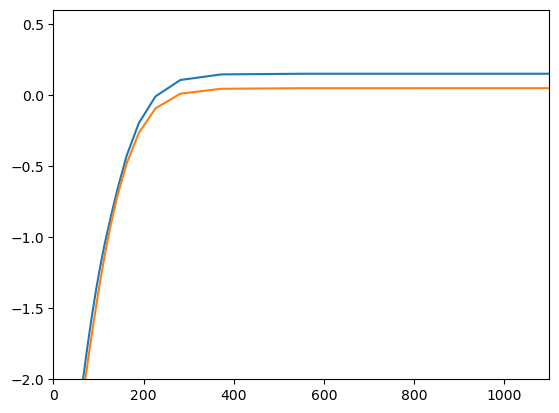

In [51]:
import numpy as np
from scipy import constants as const
from numba import jit
import matplotlib.pyplot as plt


HBAR = const.hbar / const.e                     # in units of eV.s
EV2J = const.e                                  # 1 eV in Joules
AMU2KG = const.physical_constants['atomic mass constant'][0]
ANGS2M = 1e-10                                  
factor = ANGS2M**2 * AMU2KG / HBAR / HBAR / EV2J
hb = 6.63e-34/2/np.pi

# for fast factorial calculations
LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype=np.double)

@jit
def fact(n: int) -> float:
    """Compute the factorial of n."""
    if n > 20:
        return LOOKUP_TABLE[-1] * \
            np.prod(np.array(list(range(21, n+1)), dtype=np.double))
    return LOOKUP_TABLE[n]


@jit
def herm(x: float, n: int) -> float:
    """Recursive definition of hermite polynomial."""
    if n == 0:
        return 1.
    if n == 1:
        return 2. * x

    y1 = 2. * x
    dy1 = 2.
    for i in range(2, n+1):
        yn = 2. * x * y1 - dy1
        dyn = 2. * i * y1
        y1 = yn
        dy1 = dyn
    return yn

@jit
def analytic_overlap_NM(
        DQ: float,
        w1: float,
        w2: float,
        n1: int,
        n2: int
) -> float:
    """Compute the overlap between two displaced harmonic oscillators.

    This function computes the overlap integral between two harmonic
    oscillators with frequencies w1, w2 that are displaced by DQ for the
    quantum numbers n1, n2. The integral is computed using an analytic formula
    for the overlap of two displaced harmonic oscillators. The method comes
    from B.P. Zapol, Chem. Phys. Lett. 93, 549 (1982).

    Parameters
    ----------
    DQ : float
        displacement between harmonic oscillators in amu^{1/2} Angstrom
    w1, w2 : float
        frequencies of the harmonic oscillators in eV
    n1, n2 : integer
        quantum number of the overlap integral to calculate

    Returns
    -------
    np.longdouble
        overlap of the two harmonic oscillator wavefunctions
    """
    w = np.double(w1 * w2 / (w1 + w2))
    rho = np.sqrt(factor) * np.sqrt(w / 2) * DQ
    sinfi = np.sqrt(w1) / np.sqrt(w1 + w2)
    cosfi = np.sqrt(w2) / np.sqrt(w1 + w2)

    Pr1 = (-1)**n1 * np.sqrt(2 * cosfi * sinfi) * np.exp(-rho**2)
    Ix = 0.
    k1 = n2 // 2
    k2 = n2 % 2
    l1 = n1 // 2
    l2 = n1 % 2
    for kx in range(k1+1):
        for lx in range(l1+1):
            k = 2 * kx + k2
            l = 2 * lx + l2     # noqa: E741
            Pr2 = (fact(n1) * fact(n2))**0.5 / \
                (fact(k)*fact(l)*fact(k1-kx)*fact(l1-lx)) * \
                2**((k + l - n2 - n1) / 2)
            Pr3 = (sinfi**k)*(cosfi**l)
            # f = hermval(rho, [0.]*(k+l) + [1.])
            f = herm(np.float64(rho), k+l)
            Ix = Ix + Pr1*Pr2*Pr3*f
    return np.abs(Ix)**2

ER = 0.3*1.6e-19
DQ = 2

ET=0.01
ET=-0.004
for DE in [-ET,ET]:
    # DQ = 8 # Using  2,4,6,8
    Q = DQ*np.sqrt(9.1e-31*1836)*1e-10
    omega1 = omega2 = np.sqrt(2*ER/Q**2)*hb/1.6e-19


    @jit
    def gau(x,T):
        sig = max(0.3*omega1, 0.026/300*T)
        pref = 1/sig/np.sqrt(2*np.pi)
        expo = x/sig
        return pref * np.exp(-1/2*expo**2)

    @jit
    def lsf(T, nmax):

        k= sum([ analytic_overlap_NM(DQ, omega1, omega2, alpha, beta)  \
         * np.exp(-(alpha+0.5)*omega1/(0.026/300*T))  \
             * gau(alpha*omega1-beta*omega2-DE , T) \
                 for alpha in range(nmax) for beta in range(nmax)])

        Zi = [np.exp(-(alpha+0.5)*omega1/(0.026/300*T)) for alpha in range(nmax)]
        Z = sum(Zi)
        # k = k / Z * 2*np.pi/hb
        k = k / Z
        return (k)

    Trange = np.arange(1,500,10)
    calc = np.array([lsf(T, 40) for T in Trange ])
    print('DQ=',DQ)
#     plt.plot(Trange, calc  )

    #start conversion
    Aij =  1.6e-19 * 5e-7
    ksi = calc # in units of 1/eV
    ksi = ksi/1.6e-19
    
    rate = 2*np.pi / hb * Aij**2 * ksi np.exp(-1/F)
    time = np.log10(1/rate)
    invKT = 1/(Trange/300*0.026)
    plt.plot( invKT, time ,'-')
    #end conversion 
plt.xlim(0,1100)
plt.ylim(-2,0.6)
# plt.ylim(-100,0)
# plt.axhline(-10)
# plt.axhline(-25)
# plt.axvline(200)
# plt.axvline(500)